In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Step 1: Fetch Intraday Stock Data (1-hour interval)
def fetch_stock_data(ticker, period='30d', interval='1h'):
    df = yf.download(ticker, period=period, interval=interval)
    return df[['Close']]

In [26]:
df

Price,Close
Ticker,AAPL
Datetime,
2025-03-14 13:30:00+00:00,210.378098
2025-03-14 14:30:00+00:00,211.929993
2025-03-14 15:30:00+00:00,212.230698
2025-03-14 16:30:00+00:00,212.315002
2025-03-14 17:30:00+00:00,211.244995
...,...
2025-04-25 15:30:00+00:00,208.591293
2025-04-25 16:30:00+00:00,209.370193


In [28]:
df.head()

Price,Close
Ticker,AAPL
Datetime,
2025-03-14 13:30:00+00:00,210.378098
2025-03-14 14:30:00+00:00,211.929993
2025-03-14 15:30:00+00:00,212.230698
2025-03-14 16:30:00+00:00,212.315002
2025-03-14 17:30:00+00:00,211.244995


In [3]:
# Step 2: Prepare Data for LSTM (Predicting next 4th hour)
def prepare_data(df, lookback=60, predict_ahead=4):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df)
    X, y = [], []
    for i in range(lookback, len(scaled_data) - predict_ahead):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i + predict_ahead - 1, 0])
    return np.array(X), np.array(y), scaler

In [4]:
# Step 3: Build the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [5]:
# Fetch data
ticker = 'AAPL'  # Change as needed
df = fetch_stock_data(ticker)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
# Prepare data
lookback = 60  # Hours used for prediction
predict_ahead = 4  # Predict 4th hour ahead
X, y, scaler = prepare_data(df, lookback, predict_ahead)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [7]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [30]:
# Build and train model
model = build_lstm_model((X_train.shape[1], 1))
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10


C:\Users\anush\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.2721
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0559
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0563
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0499
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0559
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0436
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0431
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0464
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0355
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0318


In [9]:
# Predict next 4th hour stock price
last_lookback_hours = df[-lookback:].values
last_lookback_scaled = scaler.transform(last_lookback_hours)
last_lookback_scaled = last_lookback_scaled.reshape(1, lookback, 1)
predicted_price = scaler.inverse_transform(model.predict(last_lookback_scaled))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


In [10]:
print(f'Predicted Closing Price for Next 4th Hour: ${predicted_price[0][0]:.2f}')

Predicted Closing Price for Next 4th Hour: $202.61


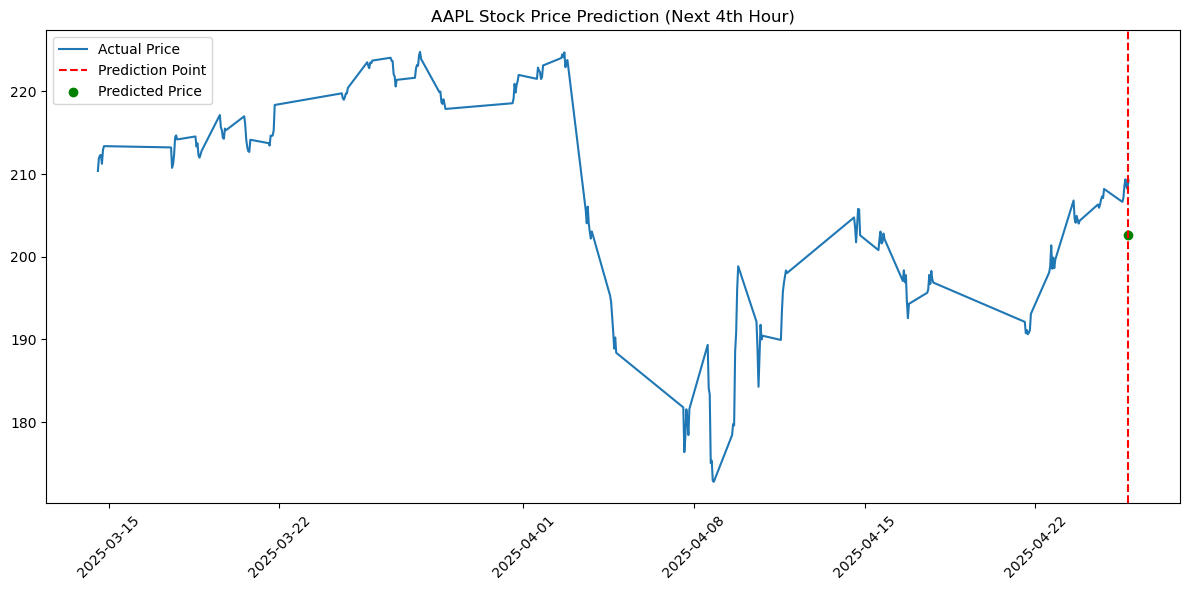

In [11]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Actual Price')
plt.axvline(df.index[-1], color='red', linestyle='--', label='Prediction Point')
plt.scatter(df.index[-1], predicted_price[0][0], color='green', label='Predicted Price')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction (Next 4th Hour)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_percentage_error

# Inverse transform the test predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform actual y_test values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Assuming predictions and actual are already inverse-transformed
mape = mean_absolute_percentage_error(actual, predictions)
accuracy = 100 - mape * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Approx. Prediction Accuracy: {accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
Mean Absolute Percentage Error (MAPE): 3.40%
Approx. Prediction Accuracy: 96.60%
